IMPORTING REQUIRED LIBRARIES

In [170]:
import tensorflow as tf
import os
import numpy as np
import cv2
import imghdr
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Softmax,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.models import load_model

In [73]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
  tf.config.experimental.set_memory_growth(i,True)

In [74]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [75]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [76]:
exts=['jpg','jpeg','bmp','png']

In [77]:
dirr='/content/gdrive/MyDrive/image_classification'

In [78]:
for ic in os.listdir(dirr):
  for image in os.listdir(os.path.join(dirr,ic)):
    path=os.path.join(dirr,ic,image)
    try:
      img=cv2.imread(path)
      ext=imghdr.what(path)
      if ext not in exts:
        print('image not in ext list{}'.format(path))
        os.remove(path)
    except Exception as e:
      print('issue with image {}'.format(path))

data preprocessing and pipelining

In [79]:
data=tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/image_classification',batch_size=32)
iterator=data.as_numpy_iterator()
bt=iterator.next()
bt[1] # we are taking images in batches of 16 ; to reduce the computational costs as larger batch sizes are going to need more cpu perfomance

Found 397 files belonging to 4 classes.


array([3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 1, 0, 0, 2, 3, 3, 2, 2, 3, 3, 2, 0,
       0, 1, 3, 3, 2, 2, 3, 1, 0, 3], dtype=int32)

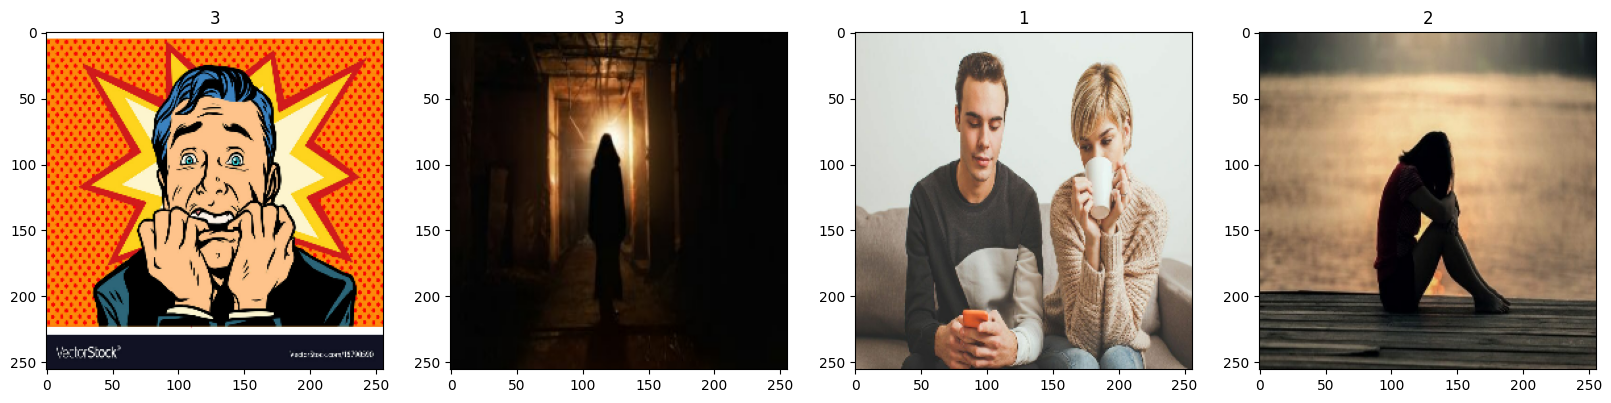

In [80]:
batch=iterator.next()
fig,ax=plt.subplots(figsize=(20,20),ncols=4)
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])
  #0-happy
  #1-jealous
  #2-sad
  #3-scared

In [81]:
data=data.map(lambda x,y:(x/255,y)) #scaling the pixel values to a value in between 0 and 1

In [82]:
data.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

training testing and dev split 


In [83]:
train=data.take(int(len(data)*0.65)+1)
dev=data.skip(int(len(data)*0.65)+1).take(int(len(data)*0.25))
test=data.skip(int(len(data)*0.65)+1+int(len(data)*0.25)).take(int(len(data)*0.1))

In [84]:
len(train)+len(test)+len(dev)

13

In [85]:

model=Sequential()


model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [86]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

In [87]:
log='/content/gdrive/MyDrive/log'

In [88]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log)

In [89]:
learn=model.fit(train,epochs=30,validation_data=dev,callbacks=[tensorboard_callback])

Epoch 1/30
9/9 [==============================] - 10s 678ms/step - loss: 1.4476 - accuracy: 0.2431 - val_loss: 1.3378 - val_accuracy: 0.3854
Epoch 2/30
9/9 [==============================] - 7s 628ms/step - loss: 1.3249 - accuracy: 0.4271 - val_loss: 1.1867 - val_accuracy: 0.5833
Epoch 3/30
9/9 [==============================] - 9s 730ms/step - loss: 1.1585 - accuracy: 0.5243 - val_loss: 0.9717 - val_accuracy: 0.6250
Epoch 4/30
9/9 [==============================] - 9s 804ms/step - loss: 1.1057 - accuracy: 0.5451 - val_loss: 0.9854 - val_accuracy: 0.6562
Epoch 5/30
9/9 [==============================] - 7s 625ms/step - loss: 0.8944 - accuracy: 0.6771 - val_loss: 0.7709 - val_accuracy: 0.6875
Epoch 6/30
9/9 [==============================] - 8s 631ms/step - loss: 0.5995 - accuracy: 0.7917 - val_loss: 0.3182 - val_accuracy: 0.9167
Epoch 7/30
9/9 [==============================] - 9s 864ms/step - loss: 0.4195 - accuracy: 0.8507 - val_loss: 0.3086 - val_accuracy: 0.9167
Epoch 8/30
9/9 [===

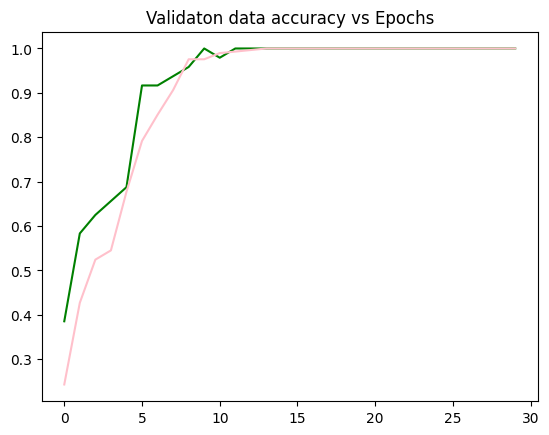

In [125]:

plt.plot(learn.history['val_accuracy'],color='green')

plt.plot(learn.history['accuracy'],color='pink')
plt.title('Validaton data accuracy vs Epochs')
#plt.subplot(1,2,2)
#plt.plot(learn.history['loss'],color='red')
#plt.subplot(1,2,2)
#plt.plot(learn.history['val_loss'],color='blue')
#plt.title('LOSS')
plt.show()

In [91]:
for batch in test.as_numpy_iterator():
  X,Y=batch 
  score = model.evaluate(X,Y, verbose=0)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}') #evaluating model

Test loss: 8.649704250274226e-05 / Test accuracy: 1.0


Testing Our model on newer images

In [171]:
img=cv2.imread('/content/gdrive/MyDrive/testing/images.jpeg')

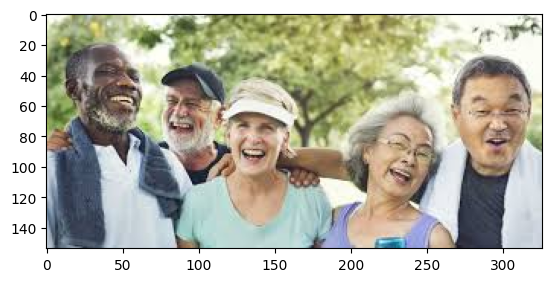

In [154]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

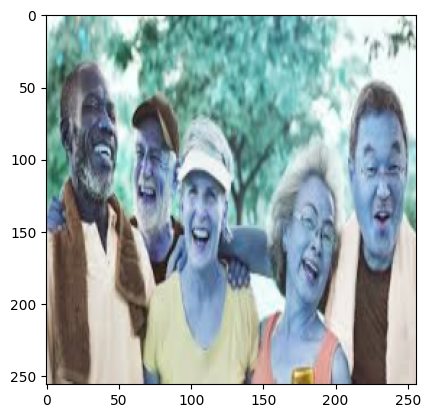

In [155]:
rz = tf.image.resize(img, (256,256))
plt.imshow(rz.numpy().astype(int))
plt.show()

In [156]:

rz=rz/255 #normaliziing the pixels to have values between 0 and 1

In [157]:
yh=model.predict(np.expand_dims(rz,0))
yh.shape

1/1 [==============================] - 0s 20ms/step


(1, 4)

In [158]:
def classify(yh):
  if(yh[0][0]>0.6):
    return ('happy')
  elif(yh[0][1]>0.6):
    return ('jealous')
  elif(yh[0][2]>0.6):
    return ('sad')
  elif(yh[0][3]>0.6):
    return ('scared')
  else:
    print('give a clearer image')

In [159]:
classify(yh)

'happy'

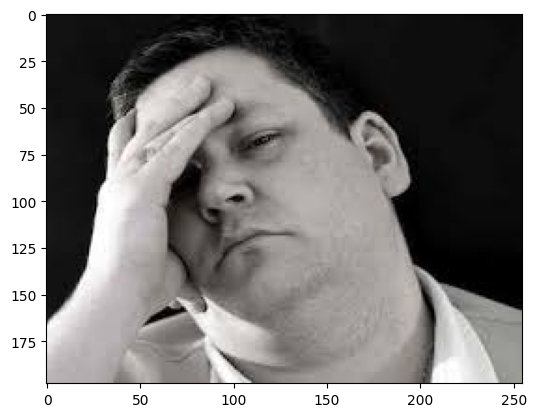

In [172]:
sd=cv2.imread('/content/gdrive/MyDrive/testing/sad.jpeg')
plt.imshow(cv2.cvtColor(sd,cv2.COLOR_BGR2RGB))
plt.show()

In [165]:
resz = tf.image.resize(sd, (256,256))
resz=resz/255 #normaliziing the pixels to have values between 0 and 1

In [167]:
yh=model.predict(np.expand_dims(resz,0))
yh.shape
print(yh)

1/1 [==============================] - 0s 33ms/step
[[8.9070375e-07 2.6513760e-06 9.9492741e-01 5.0690919e-03]]


In [168]:
classify(yh)

'sad'

Saving the model so as to allow usage at a later date or on another device

In [173]:
model.save(os.path.join('/content/gdrive/MyDrive/model_classification','emotioclassifier.h5'))